In [91]:
import requests
import re
import json
import pandas as pd
import numpy as np
from itertools import chain
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

In [92]:
metric_to_principle = {
    "unique_identifier": "findable",
    "metadata_identifier_persistence": "findable",
    "data_identifier_persistence": "findable",
    "structured_metadata": "findable",
    "grounded_metadata": "findable",
    "data_identifier_in_metadata": "findable",
    "metadata_identifier_in_metadata": "findable",
    "searchable": "findable",
    "data_protocol": "accessible",
    "metadata_protocol": "accessible",
    "data_authorization": "accessible",
    "metadata_authorization": "accessible",
    "metadata_persistence": "accessible",
    "metadata_kr_language_weak": "interoperable",
    "metadata_kr_language_strong": "interoperable",
    "data_kr_language_weak": "interoperable",
    "data_kr_language_strong": "interoperable",
    "metadata_uses_fair_vocabularies_weak": "interoperable",
    "metadata_uses_fair_vocabularies_strong": "interoperable",
    "metadata_contains_outward_links": "interoperable",
    "metadata_includes_license_weak": "reusable",
    "metadata_includes_license_strong": "reusable"
}

metrics_ordered = list(metric_to_principle.keys())

In [93]:
def build_result_json(assessment_result):
    if assessment_result is None:
        return None
    content = assessment_result.get("contains")
    result_list = []
    for k in content.keys():
        score_key = "http://semanticscience.org/resource/SIO_000300"
        metric = re.search(r'(?<=https://w3id.org/FAIR_Tests/tests/gen2_).*$', k).group()
        try:
            score = content.get(k)[0].get(score_key)[0].get("@value")
        except AttributeError:
            score = None
        result_dict = {
            "metric": metric,
            "score": score
        }
        result_list.append(result_dict)
    return result_list

In [94]:
def get_assessment(url):
    global count
    print(count)
    print(url)

    api_connection = "https://api.fair-enough.semanticscience.org/evaluations"

    request_body = {
        "subject": url,
        "collection": "fair-evaluator-maturity-indicators"
    }


    response = requests.post(api_connection, json=request_body)

    if response.status_code != 201:
        print(response.status_code)
        print("_______________________________________")
        count += 1
        return None

    if response is None:
        return None

    result = build_result_json(response.json())
    print("_______________________________________")
    count += 1
    return result

In [95]:
def get_metrics_from_result(assessment_result):
    return [item.get('metric') for item in assessment_result]

def get_scores_from_result(assessment_result):
    return [item.get('score') for item in assessment_result]

In [96]:
def print_summary_stats(scores):
    print("Mean: "+str(scores.mean()))
    print("Median: "+str(+scores.median()))
    print("Min: "+str(scores.min()))
    print("Max: "+str(scores.max()))

# Papers

In [97]:
def expand_paper_df(df):
    df_exp = pd.DataFrame()
    df_exp["paper"] = list(chain.from_iterable([[x]*22 for x in df["paper"]]))
    try:
        df_exp["doi"] = list(chain.from_iterable([[x]*22 for x in df["doi"]]))
    except KeyError:
        pass
    df_exp["research_field"] = list(chain.from_iterable([[x]*22 for x in df["research_field_label"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp["score_total"] = list(chain.from_iterable([[1]*22 for x in df["paper"]]))
    if "doi" in df_exp.columns:
        df_exp = df_exp[["paper", "doi", "research_field", "metric", "score_earned", "score_total"]]
    else:
        df_exp = df_exp[["paper", "research_field", "metric", "score_earned", "score_total"]]
    return df_exp

## Papers via DOI

In [98]:
%%script false --no-raise-error
paper_doi_df = pd.read_csv("raw_data/orkg_papers_2023-03-29.csv", index_col=0)
paper_doi_df = paper_doi_df[paper_doi_df["doi"].isna() == False]
count = 0
paper_doi_df["assessment_result"] = paper_doi_df["doi"].map(lambda x: get_assessment(url="https://doi.org/" + x))
paper_doi_df.to_csv("assessed_data/paper_doi_df_fenough_assessment.csv")
paper_doi_df

Couldn't find program: 'false'


In [99]:
paper_doi_df = pd.read_csv("assessed_data/paper_doi_df_fenough_assessment.csv", index_col=0)
paper_doi_df = paper_doi_df[paper_doi_df["assessment_result"].isna() == False].reset_index(drop=True)
paper_doi_df["assessment_result"] = paper_doi_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
paper_doi_df["assessment_result"] = paper_doi_df["assessment_result"].map(lambda x: x.replace("None", "\"None\""))
paper_doi_df["assessment_result"] = paper_doi_df["assessment_result"].map(lambda x: json.loads(x))
paper_doi_df

,paper,doi,research_field_label,assessment_result
0,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,"[{'metric': 'unique_identifier', 'score': '1'}..."
1,http://orkg.org/orkg/resource/R107618,10.1007/s11423-020-09885-z,Learner-Interface Interaction,"[{'metric': 'metadata_identifier_persistence',..."
2,http://orkg.org/orkg/resource/R107663,10.1111/1467-8535.00213,Learner-Interface Interaction,"[{'metric': 'metadata_authorization', 'score':..."
3,http://orkg.org/orkg/resource/R107834,10.32870/Ap.v12n2.1910,Learner-Interface Interaction,"[{'metric': 'unique_identifier', 'score': '1'}..."
4,http://orkg.org/orkg/resource/R107843,10.19173/irrodl.v4i2.149,Learner-Interface Interaction,"[{'metric': 'unique_identifier', 'score': '1'}..."
...,...,...,...,...
4893,http://orkg.org/orkg/resource/R8441,10.1016/j.jbiotec.2013.12.009,Systems Biology,"[{'metric': 'metadata_identifier_persistence',..."
4894,http://orkg.org/orkg/resource/R9154,10.1073/pnas.1913007117,Life Sciences,"[{'metric': 'unique_identifier', 'score': '1'}..."
4895,http://orkg.org/orkg/resource/R9190,10.1007/978-3-319-54064-1_3,Biotechnology,"[{'metric': 'unique_identifier', 'score': '1'}..."
4896,http://orkg.org/orkg/resource/R9295,10.1038/nprot.2016.182,Biotechnology,"[{'metric': 'metadata_identifier_persistence',..."


In [100]:
paper_doi_df_assessed = expand_paper_df(paper_doi_df)
paper_doi_df_assessed[paper_doi_df_assessed["score_earned"] == "None"].value_counts("metric")

metric
metadata_uses_fair_vocabularies_strong    59
metadata_kr_language_weak                 59
metadata_includes_license_weak            58
metadata_kr_language_strong               57
metadata_protocol                         55
metadata_contains_outward_links           46
metadata_identifier_in_metadata           44
metadata_includes_license_strong          42
data_kr_language_weak                     37
metadata_persistence                      37
data_identifier_persistence               34
data_protocol                             34
data_authorization                        33
data_kr_language_strong                   33
data_identifier_in_metadata               30
grounded_metadata                         30
searchable                                30
metadata_uses_fair_vocabularies_weak      24
structured_metadata                       23
metadata_authorization                     1
dtype: int64

In [101]:
paper_doi_df_assessed["score_earned"] = paper_doi_df_assessed["score_earned"].map(lambda x: x.replace("None", "0"))
paper_doi_df_assessed["score_earned"] = paper_doi_df_assessed["score_earned"].map(lambda x: int(x))
paper_doi_df_assessed

,paper,doi,research_field,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,unique_identifier,1,1
1,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,metadata_authorization,1,1
2,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,metadata_identifier_persistence,1,1
3,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,metadata_kr_language_strong,1,1
4,http://orkg.org/orkg/resource/R1004,10.1186/s12866-016-0676-9,Bioinformatics,data_protocol,0,1
...,...,...,...,...,...,...
107751,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,structured_metadata,1,1
107752,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,data_protocol,0,1
107753,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,data_identifier_in_metadata,0,1
107754,http://orkg.org/orkg/resource/R9639,10.1007/978-3-030-30760-8_18,Computer Sciences,metadata_uses_fair_vocabularies_weak,1,1


In [102]:
paper_doi_df_total = paper_doi_df_assessed.groupby("paper").agg({"doi": "first", "research_field": "first", "score_earned": "sum"}).reset_index()
print_summary_stats(paper_doi_df_total["score_earned"])

Mean: 10.125969783585138
Median: 11.0
Min: 3
Max: 13


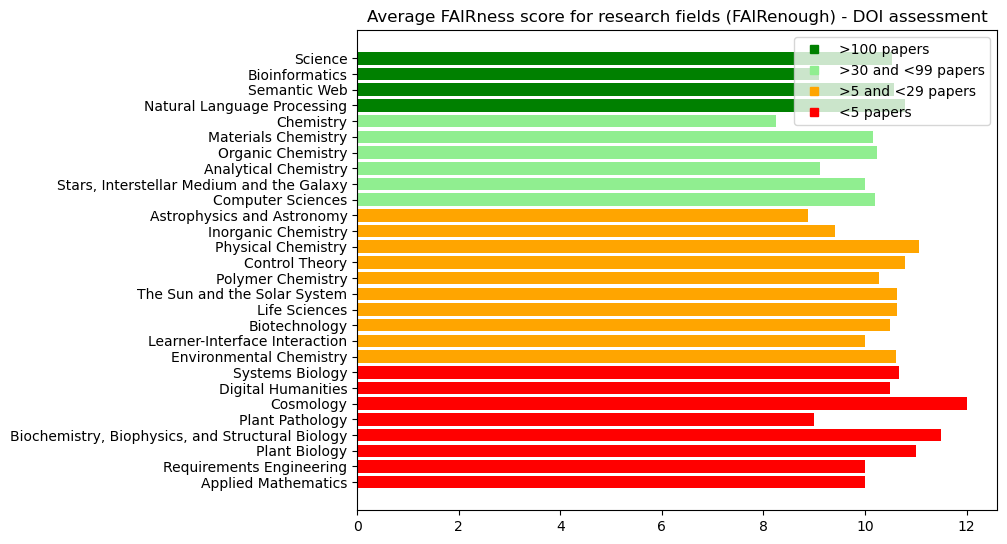

In [103]:
eval3_df = paper_doi_df_total.groupby("research_field").agg({"score_earned": "sum"})
eval3_df["counts"] = paper_doi_df_total["research_field"].value_counts()
eval3_df = eval3_df.sort_values("counts")
eval3_df["avg_score"] = eval3_df["score_earned"] / eval3_df["counts"]
eval3_df = eval3_df.drop(labels=["score_earned"], axis=1)
eval3_df = eval3_df.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = eval3_df['research_field']
avg_scores = eval3_df['avg_score']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in eval3_df["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (FAIRenough) - DOI assessment")
plt.show()

In [104]:
paper_doi_df_principle = paper_doi_df_assessed
paper_doi_df_principle["principle"] = paper_doi_df_principle["metric"].map(lambda x: metric_to_principle[x])
paper_doi_df_principle = paper_doi_df_principle.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_doi_df_principle["score_earned"] = paper_doi_df_principle["score_earned"]/len(paper_doi_df)
paper_doi_df_principle["score_total"] = paper_doi_df_principle["score_total"]/len(paper_doi_df)
paper_doi_df_principle['principle'] = pd.Categorical(paper_doi_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
paper_doi_df_principle = paper_doi_df_principle.sort_values('principle')
paper_doi_df_principle

,principle,score_earned,score_total
1,findable,3.939976,8.0
0,accessible,1.988567,5.0
2,interoperable,4.097795,7.0
3,reusable,0.099633,2.0


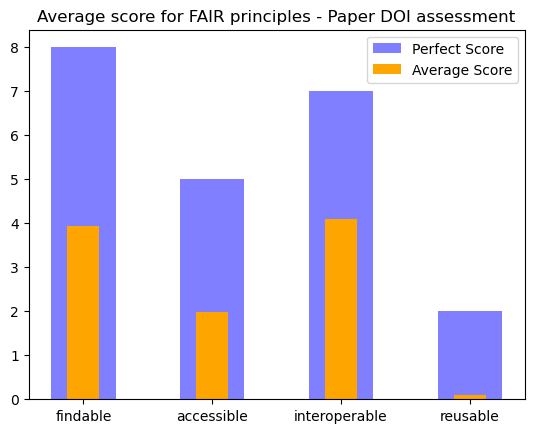

In [105]:
width = 0.5
perfect_scores = [8, 5, 7, 2]
actual_scores = paper_doi_df_principle['score_earned']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_doi_df_principle['principle'] )
plt.title("Average score for FAIR principles - Paper DOI assessment")
plt.legend()
plt.show()

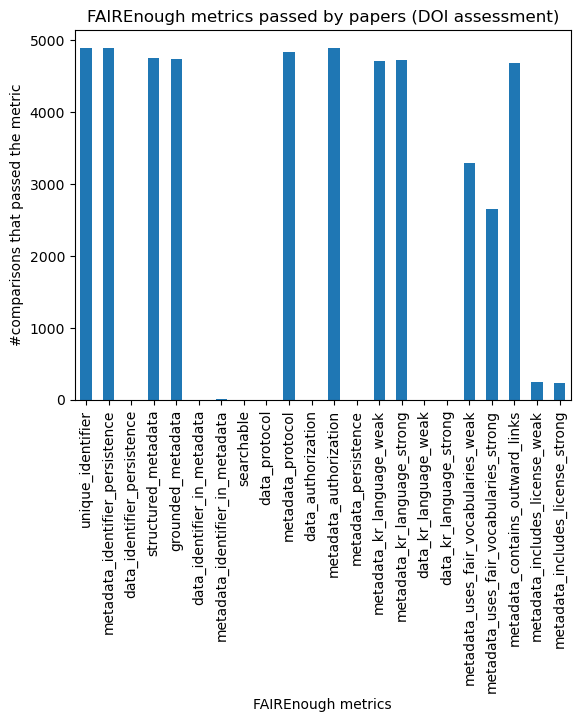

In [106]:
paper_doi_df_submetrics = paper_doi_df_assessed
paper_doi_df_submetrics = paper_doi_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()

paper_doi_df_submetrics["metric"] = pd.Categorical(paper_doi_df_submetrics["metric"], metrics_ordered)
paper_doi_df_submetrics = paper_doi_df_submetrics.sort_values("metric")

paper_doi_df_submetrics["score_earned"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, metrics_ordered)
plt.title("FAIREnough metrics passed by papers (DOI assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIREnough metrics")
plt.show()

## Papers via ORKG resource URL

In [107]:
%%script false --no-raise-error
paper_url_df = pd.read_csv("raw_data/paper_query_result_2023-03-29.csv", encoding="ISO-8859-1", index_col=0).reset_index()
paper_url_df = paper_url_df.groupby("paper").agg({"research_field_label": "first"}).reset_index()

count = 0
with open("assessed_data/paper_url_df_fenough_assessment.csv", "a") as csvfile:
    csvfile.write("paper,research_field,assessment_result\n")
    for i in range(len(paper_url_df)):
        paper = paper_url_df.iloc[i]["paper"]
        research_field = paper_url_df.iloc[i]["research_field_label"]
        assessment_result = get_assessment(paper)
        csvfile.write(paper+","+research_field+",\""+str(assessment_result)+"\"\n")

Couldn't find program: 'false'


In [108]:
%%script false --no-raise-error
def correct_research_field(field):
    if field == "Stars Interstellar Medium and the Galaxy":
        field = "Stars, Interstellar Medium and the Galaxy"
    elif field == "Biochemistry Biophysics and Structural Biology":
        field = "Biochemistry, Biophysics, and Structural Biology"
    return field

def correct_assessment(assessment):
    if assessment == "None":
        assessment = None
    return assessment

paper_url_df = pd.read_csv("assessed_data/paper_url_df_fenough_assessment.csv", index_col=0).reset_index()
paper_url_df["research_field"] = paper_url_df["research_field"].map(lambda x: correct_research_field(x))
paper_url_df["assessment_result"] = paper_url_df["assessment_result"].map(lambda x: correct_assessment(x))
paper_url_df.to_csv("assessed_data/paper_url_df_fenough_assessment.csv")

Couldn't find program: 'false'


In [109]:
paper_url_df = pd.read_csv("assessed_data/paper_url_df_fenough_assessment.csv", index_col=0)
paper_url_df = paper_url_df[paper_url_df["assessment_result"].isna() == False].reset_index(drop=True)
paper_url_df["assessment_result"] = paper_url_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
paper_url_df["assessment_result"] = paper_url_df["assessment_result"].map(lambda x: x.replace("None", "\"None\""))
paper_url_df["assessment_result"] = paper_url_df["assessment_result"].map(lambda x: json.loads(x))
paper_url_df = paper_url_df.rename(columns={"research_field": "research_field_label"})
paper_url_df

,paper,research_field_label,assessment_result
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,"[{'metric': 'metadata_identifier_persistence',..."
1,http://orkg.org/orkg/resource/R107618,Learner-Interface Interaction,"[{'metric': 'unique_identifier', 'score': '1'}..."
2,http://orkg.org/orkg/resource/R107663,Learner-Interface Interaction,"[{'metric': 'metadata_identifier_persistence',..."
3,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,"[{'metric': 'metadata_identifier_persistence',..."
4,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,"[{'metric': 'unique_identifier', 'score': '1'}..."
...,...,...,...
11652,http://orkg.org/orkg/resource/R8441,Systems Biology,"[{'metric': 'unique_identifier', 'score': '1'}..."
11653,http://orkg.org/orkg/resource/R9154,Life Sciences,"[{'metric': 'unique_identifier', 'score': '1'}..."
11654,http://orkg.org/orkg/resource/R9190,Biotechnology,"[{'metric': 'metadata_identifier_persistence',..."
11655,http://orkg.org/orkg/resource/R9295,Biotechnology,"[{'metric': 'metadata_identifier_persistence',..."


In [110]:
paper_url_df_assessed = expand_paper_df(paper_url_df)
paper_url_df_assessed[paper_url_df_assessed["score_earned"] == "None"].value_counts("metric")

metric
data_authorization                        90
data_kr_language_weak                     90
data_kr_language_strong                   80
data_identifier_in_metadata               79
data_protocol                             79
metadata_identifier_in_metadata           75
metadata_contains_outward_links           74
grounded_metadata                         67
metadata_includes_license_strong          66
structured_metadata                       65
data_identifier_persistence               58
metadata_protocol                         58
metadata_includes_license_weak            56
metadata_persistence                      54
metadata_kr_language_weak                 51
metadata_uses_fair_vocabularies_strong    48
metadata_kr_language_strong               43
metadata_uses_fair_vocabularies_weak       6
unique_identifier                          6
metadata_identifier_persistence            5
searchable                                 5
metadata_authorization                     3
dty

In [111]:
paper_url_df_assessed["score_earned"] = paper_url_df_assessed["score_earned"].map(lambda x: x.replace("None", "0"))
paper_url_df_assessed["score_earned"] = paper_url_df_assessed["score_earned"].map(lambda x: int(x))
paper_url_df_assessed

,paper,research_field,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R1004,Bioinformatics,metadata_identifier_persistence,0,1
1,http://orkg.org/orkg/resource/R1004,Bioinformatics,unique_identifier,1,1
2,http://orkg.org/orkg/resource/R1004,Bioinformatics,metadata_authorization,1,1
3,http://orkg.org/orkg/resource/R1004,Bioinformatics,structured_metadata,1,1
4,http://orkg.org/orkg/resource/R1004,Bioinformatics,grounded_metadata,1,1
...,...,...,...,...,...
256449,http://orkg.org/orkg/resource/R9639,Computer Sciences,data_protocol,0,1
256450,http://orkg.org/orkg/resource/R9639,Computer Sciences,metadata_kr_language_strong,1,1
256451,http://orkg.org/orkg/resource/R9639,Computer Sciences,data_identifier_persistence,0,1
256452,http://orkg.org/orkg/resource/R9639,Computer Sciences,metadata_uses_fair_vocabularies_strong,0,1


In [112]:
paper_url_df_total = paper_url_df_assessed.groupby("paper").agg({"research_field": "first", "score_earned": "sum"}).reset_index()
print_summary_stats(paper_url_df_total["score_earned"])

Mean: 6.974779102685082
Median: 7.0
Min: 4
Max: 7


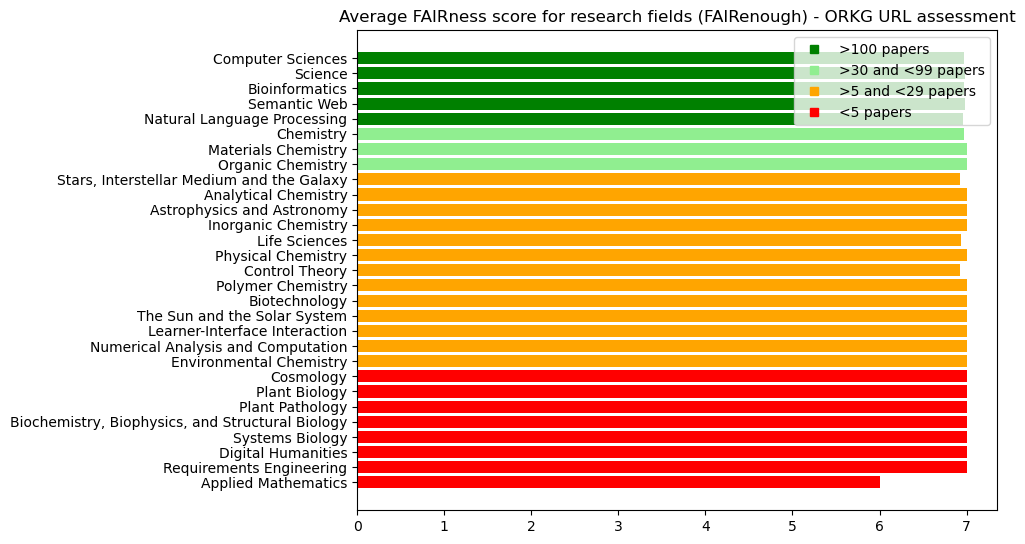

In [113]:
eval3_df = paper_url_df_total.groupby("research_field").agg({"score_earned": "sum"})
eval3_df["counts"] = paper_url_df_total["research_field"].value_counts()
eval3_df = eval3_df.sort_values("counts")
eval3_df["avg_score"] = eval3_df["score_earned"] / eval3_df["counts"]
eval3_df = eval3_df.drop(labels=["score_earned"], axis=1)
eval3_df = eval3_df.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = eval3_df['research_field']
avg_scores = eval3_df['avg_score']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in eval3_df["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (FAIRenough) - ORKG URL assessment")
plt.show()

In [114]:
paper_url_df_principle = paper_url_df_assessed
paper_url_df_principle["principle"] = paper_url_df_principle["metric"].map(lambda x: metric_to_principle[x])
paper_url_df_principle = paper_url_df_principle.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_url_df_principle["score_earned"] = paper_url_df_principle["score_earned"]/len(paper_url_df)
paper_url_df_principle["score_total"] = paper_url_df_principle["score_total"]/len(paper_url_df)
paper_url_df_principle['principle'] = pd.Categorical(paper_url_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
paper_url_df_principle = paper_url_df_principle.sort_values('principle')
paper_url_df_principle

,principle,score_earned,score_total
1,findable,2.988076,8.0
0,accessible,1.994767,5.0
2,interoperable,1.991936,7.0
3,reusable,0.000000,2.0


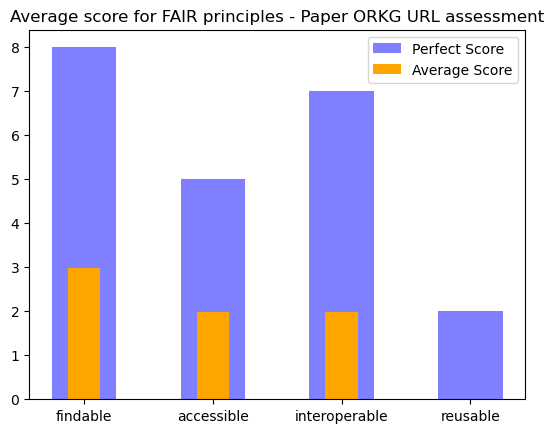

In [115]:
width = 0.5
perfect_scores = [8, 5, 7, 2]
actual_scores = paper_url_df_principle['score_earned']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_url_df_principle['principle'] )
plt.title("Average score for FAIR principles - Paper ORKG URL assessment")
plt.legend()
plt.show()

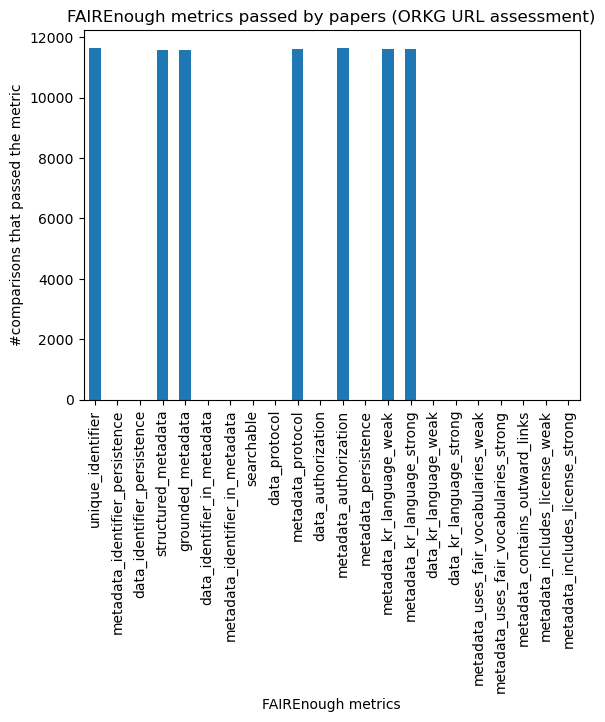

In [116]:
paper_url_df_submetrics = paper_url_df_assessed
paper_url_df_submetrics = paper_url_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()

paper_url_df_submetrics["metric"] = pd.Categorical(paper_url_df_submetrics["metric"], metrics_ordered)
paper_url_df_submetrics = paper_url_df_submetrics.sort_values("metric")

paper_url_df_submetrics["score_earned"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, metrics_ordered)
plt.title("FAIREnough metrics passed by papers (ORKG URL assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIREnough metrics")
plt.show()

## Papers via standard URL

In [117]:
%%script false --no-raise-error
paper_std_df = pd.read_csv("raw_data/paper_query_result_2023-03-29.csv", encoding="ISO-8859-1", index_col=0).reset_index()
paper_std_df = paper_std_df.groupby("paper").agg({"research_field_label": "first", "url": "first"}).reset_index()
paper_std_df = paper_std_df[paper_std_df["url"].isna() == False].reset_index(drop=True)

count = 0
with open("assessed_data/paper_std_df_fenough_assessment.csv", "a") as csvfile:
    csvfile.write("paper,url,research_field,assessment_result\n")
    for i in range(len(paper_std_df)):
        paper = paper_std_df.iloc[i]["paper"]
        url = paper_std_df.iloc[i]["url"]
        research_field = paper_std_df.iloc[i]["research_field_label"]
        assessment_result = get_assessment(url)
        csvfile.write(paper+","+url+","+research_field+",\""+str(assessment_result)+"\"\n")

Couldn't find program: 'false'


In [118]:
%%script false --no-raise-error
def correct_research_field(field):
    if field == "Stars Interstellar Medium and the Galaxy":
        field = "Stars, Interstellar Medium and the Galaxy"
    elif field == "Biochemistry Biophysics and Structural Biology":
        field = "Biochemistry, Biophysics, and Structural Biology"
    return field

def correct_urls(url):
    if url == "https://www.dl.begellhouse.com/journals/52034eb04b657aea67004a5b6ddaf80758efb4b506c3f902.html":
        url = "http://orkg.org/orkg/resource/R369982,https://www.dl.begellhouse.com/journals/52034eb04b657aea,67004a5b6ddaf807,58efb4b506c3f902.html"
    elif url == "https://www.sciencedirect.com/science/article/pii/S0950705122004038#:~:text=In%20unsupervised%20image%20anomaly%20segmentation%2C%20knowledge%20distillation%20isthe%20student%20and%20teacher%20networks%20indicate%20anomaly%20scores..pdf":
        url = "https://www.sciencedirect.com/science/article/pii/S0950705122004038#:~:text=In%20unsupervised%20image%20anomaly%20segmentation%2C%20knowledge%20distillation%20is,the%20student%20and%20teacher%20networks%20indicate%20anomaly%20scores..pdf"
    return url

def correct_assessment(assessment):
    if assessment == "None":
        assessment = None
    return assessment

paper_std_df = pd.read_csv("assessed_data/paper_std_df_fenough_assessment.csv", index_col=0).reset_index()
paper_std_df["research_field"] = paper_std_df["research_field"].map(lambda x: correct_research_field(x))
paper_std_df["assessment_result"] = paper_std_df["assessment_result"].map(lambda x: correct_assessment(x))
paper_std_df["url"] = paper_std_df["url"].map(lambda x: correct_urls(x))
paper_std_df.to_csv("assessed_data/paper_std_df_fenough_assessment.csv")

Couldn't find program: 'false'


In [119]:
paper_std_df = pd.read_csv("assessed_data/paper_std_df_fenough_assessment.csv", index_col=0)
paper_std_df = paper_std_df[paper_std_df["assessment_result"].isna() == False].reset_index(drop=True)
paper_std_df["assessment_result"] = paper_std_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
paper_std_df["assessment_result"] = paper_std_df["assessment_result"].map(lambda x: x.replace("None", "\"None\""))
paper_std_df["assessment_result"] = paper_std_df["assessment_result"].map(lambda x: json.loads(x))
paper_std_df = paper_std_df.rename(columns={"research_field": "research_field_label"})
paper_std_df

,paper,research_field_label,assessment_result,url
0,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,"[{'metric': 'unique_identifier', 'score': '1'}...",http://www.udgvirtual.udg.mx/apertura/index.ph...
1,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,"[{'metric': 'metadata_identifier_persistence',...",http://www.irrodl.org/index.php/irrodl/article...
2,http://orkg.org/orkg/resource/R108529,Computer Sciences,"[{'metric': 'metadata_identifier_persistence',...",https://dl.acm.org/doi/10.1145/3201064.3201083
3,http://orkg.org/orkg/resource/R108693,Biotechnology,"[{'metric': 'metadata_identifier_persistence',...",https://doi.org/10.1080/21645698.2020.1794489
4,http://orkg.org/orkg/resource/R108704,Plant Pathology,"[{'metric': 'unique_identifier', 'score': '1'}...",https://apsjournals.apsnet.org/doi/10.1094/PDI...
...,...,...,...,...
7810,http://orkg.org/orkg/resource/R78136,Life Sciences,"[{'metric': 'unique_identifier', 'score': '1'}...",https://www.sciencedirect.com/science/article/...
7811,http://orkg.org/orkg/resource/R78139,Life Sciences,"[{'metric': 'grounded_metadata', 'score': '0'}...",https://www.sciencedirect.com/science/article/...
7812,http://orkg.org/orkg/resource/R78145,Life Sciences,"[{'metric': 'data_identifier_persistence', 'sc...",https://www.sciencedirect.com/science/article/...
7813,http://orkg.org/orkg/resource/R78301,Environmental Chemistry,"[{'metric': 'metadata_identifier_persistence',...",http://www.sciepub.com/JEPHH/abstract/8843


In [120]:
paper_std_df_assessed = expand_paper_df(paper_std_df)
paper_std_df_assessed[paper_std_df_assessed["score_earned"] == "None"].value_counts("metric")

metric
metadata_uses_fair_vocabularies_strong    16
metadata_identifier_in_metadata           15
data_kr_language_strong                   15
metadata_kr_language_strong               14
metadata_kr_language_weak                 12
metadata_includes_license_weak            11
searchable                                10
metadata_persistence                      10
data_authorization                        10
metadata_contains_outward_links           10
data_identifier_in_metadata                9
grounded_metadata                          9
metadata_includes_license_strong           8
metadata_uses_fair_vocabularies_weak       8
data_identifier_persistence                8
metadata_protocol                          6
structured_metadata                        6
data_protocol                              5
data_kr_language_weak                      3
unique_identifier                          2
dtype: int64

In [121]:
paper_std_df_assessed["score_earned"] = paper_std_df_assessed["score_earned"].map(lambda x: x.replace("None", "0"))
paper_std_df_assessed["score_earned"] = paper_std_df_assessed["score_earned"].map(lambda x: int(x))
paper_std_df_assessed

,paper,research_field,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,unique_identifier,1,1
1,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,metadata_identifier_persistence,0,1
2,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,metadata_authorization,1,1
3,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,metadata_includes_license_strong,0,1
4,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,metadata_includes_license_weak,0,1
...,...,...,...,...,...
171925,http://orkg.org/orkg/resource/R78345,Physical Chemistry,metadata_persistence,0,1
171926,http://orkg.org/orkg/resource/R78345,Physical Chemistry,metadata_uses_fair_vocabularies_weak,0,1
171927,http://orkg.org/orkg/resource/R78345,Physical Chemistry,searchable,0,1
171928,http://orkg.org/orkg/resource/R78345,Physical Chemistry,metadata_uses_fair_vocabularies_strong,0,1


In [122]:
paper_std_df_total = paper_std_df_assessed.groupby("paper").agg({"research_field": "first", "score_earned": "sum"}).reset_index()
print_summary_stats(paper_std_df_total["score_earned"])

Mean: 3.4591170825335893
Median: 3.0
Min: 0
Max: 13


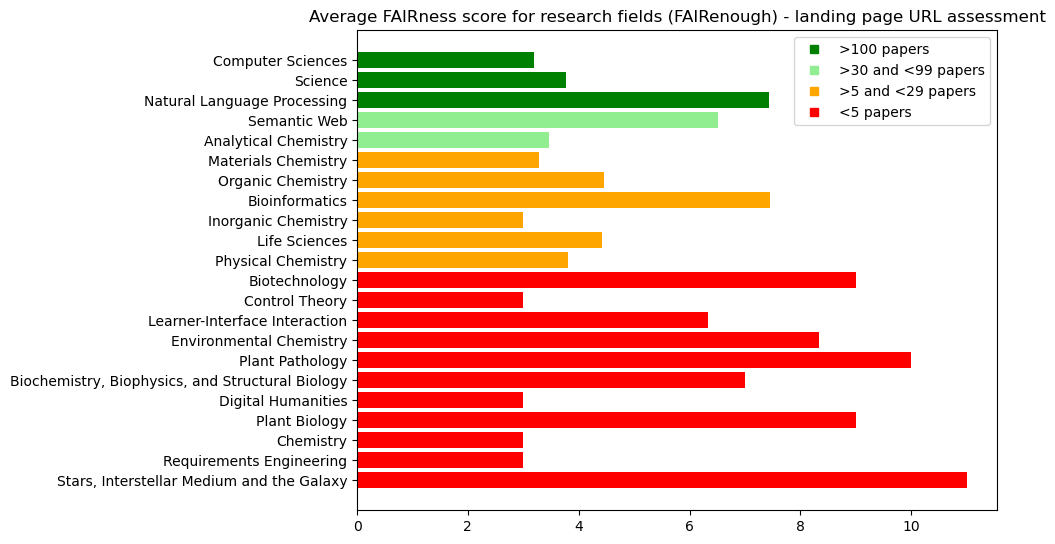

In [123]:
eval5_df = paper_std_df_total.groupby("research_field").agg({"score_earned": "sum"})
eval5_df["counts"] = paper_std_df_total["research_field"].value_counts()
eval5_df = eval5_df.sort_values("counts")
eval5_df["avg_score"] = eval5_df["score_earned"] / eval5_df["counts"]
eval5_df = eval5_df.drop(labels=["score_earned"], axis=1)
eval5_df = eval5_df.reset_index()

plot = plt.figure()
ax = plot.add_axes([0,0,1,1])
fields = eval5_df['research_field']
avg_scores = eval5_df['avg_score']
counts_color = [{p<5: 'red', 5<=p<30: 'orange', 30<=p<=100: 'lightgreen', p>100: 'green'}[True] for p in eval5_df["counts"]]
ax.barh(fields, avg_scores, color=counts_color)
leg_red = mlines.Line2D([], [], color="red", marker="s", ls='', label="<5 papers")
leg_orange = mlines.Line2D([], [], color="orange", marker="s", ls='', label=">5 and <29 papers")
leg_lightgreen = mlines.Line2D([], [], color="lightgreen", marker="s", ls='', label=">30 and <99 papers")
leg_green = mlines.Line2D([], [], color="green", marker="s", ls='', label=">100 papers")
plt.legend(handles=[leg_green, leg_lightgreen, leg_orange, leg_red])
plt.title("Average FAIRness score for research fields (FAIRenough) - landing page URL assessment")
plt.show()

In [124]:
paper_std_df_principle = paper_std_df_assessed
paper_std_df_principle["principle"] = paper_std_df_principle["metric"].map(lambda x: metric_to_principle[x])
paper_std_df_principle = paper_std_df_principle.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
paper_std_df_principle["score_earned"] = paper_std_df_principle["score_earned"]/len(paper_std_df)
paper_std_df_principle["score_total"] = paper_std_df_principle["score_total"]/len(paper_std_df)
paper_std_df_principle['principle'] = pd.Categorical(paper_std_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
paper_std_df_principle = paper_std_df_principle.sort_values('principle')
paper_std_df_principle

,principle,score_earned,score_total
1,findable,1.186436,8.0
0,accessible,1.996673,5.0
2,interoperable,0.256942,7.0
3,reusable,0.019066,2.0


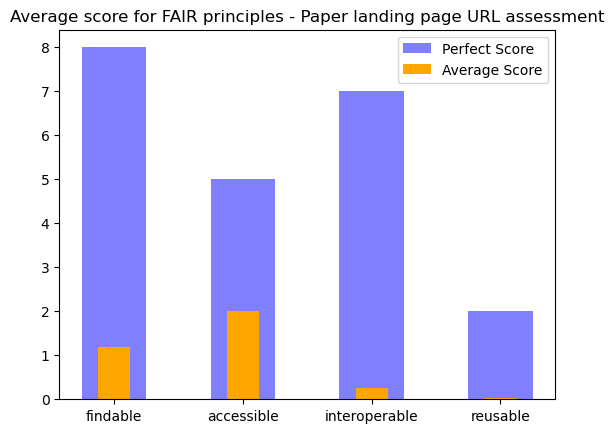

In [125]:
width = 0.5
perfect_scores = [8, 5, 7, 2]
actual_scores = paper_std_df_principle['score_earned']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, paper_std_df_principle['principle'] )
plt.title("Average score for FAIR principles - Paper landing page URL assessment")
plt.legend()
plt.show()

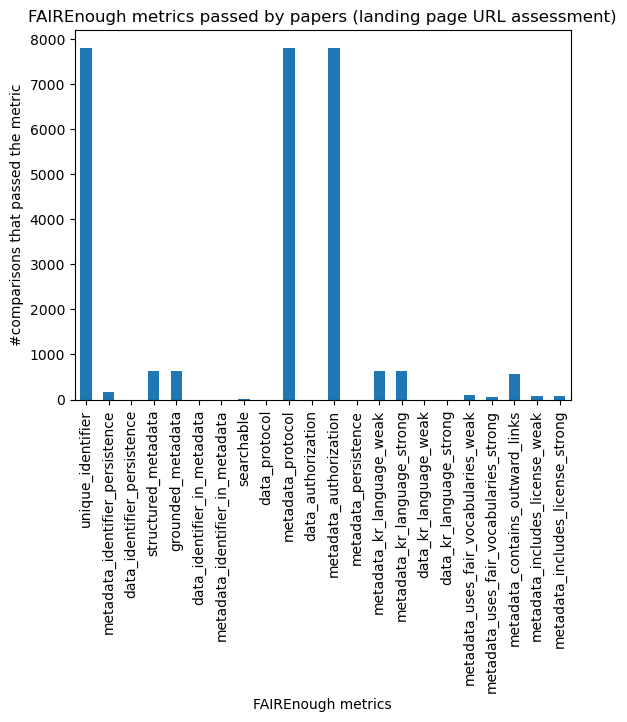

In [126]:
paper_std_df_submetrics = paper_std_df_assessed
paper_std_df_submetrics = paper_std_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()

paper_std_df_submetrics["metric"] = pd.Categorical(paper_std_df_submetrics["metric"], metrics_ordered)
paper_std_df_submetrics = paper_std_df_submetrics.sort_values("metric")

paper_std_df_submetrics["score_earned"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, metrics_ordered)
plt.title("FAIREnough metrics passed by papers (landing page URL assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIREnough metrics")
plt.show()

## Comparison of Papers

In [138]:
doi_url_df = pd.merge(paper_doi_df_total, paper_url_df_total, on=["paper", "research_field"], suffixes=("_doi", "_url"))
doi_url_std_df = pd.merge(doi_url_df, paper_std_df_total, on=["paper", "research_field"])
doi_url_std_df = doi_url_std_df.rename(columns={"score_earned": "score_earned_std"})
doi_url_std_df = doi_url_std_df[["paper", "research_field", "doi", "score_earned_doi", "score_earned_url", "score_earned_std"]]
doi_url_std_df

,paper,research_field,doi,score_earned_doi,score_earned_url,score_earned_std
0,http://orkg.org/orkg/resource/R107834,Learner-Interface Interaction,10.32870/Ap.v12n2.1910,11,7,8
1,http://orkg.org/orkg/resource/R107843,Learner-Interface Interaction,10.19173/irrodl.v4i2.149,9,7,8
2,http://orkg.org/orkg/resource/R108529,Computer Sciences,10.1145/3201064.3201083,9,7,3
3,http://orkg.org/orkg/resource/R108713,Plant Pathology,10.1007/s10658-014-0409-6,10,7,10
4,http://orkg.org/orkg/resource/R108865,Bioinformatics,10.1186/s12859-019-3284-5,12,7,13
...,...,...,...,...,...,...
583,http://orkg.org/orkg/resource/R74963,"Biochemistry, Biophysics, and Structural Biology",10.1186/1471-2105-10-168,12,7,11
584,http://orkg.org/orkg/resource/R74966,"Biochemistry, Biophysics, and Structural Biology",10.1021/acs.jctc.7b00500,11,7,3
585,http://orkg.org/orkg/resource/R75702,Environmental Chemistry,10.22034/ajgc.2021.113192,10,7,7
586,http://orkg.org/orkg/resource/R78118,Environmental Chemistry,10.12691/env-2-1-5,11,7,9


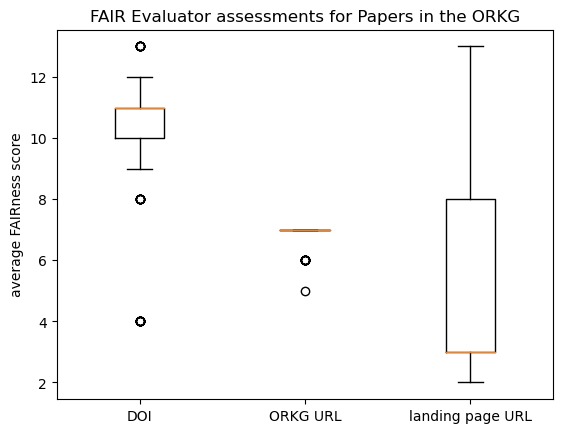

In [140]:
assessement_data_merged = [doi_url_std_df["score_earned_doi"], doi_url_std_df["score_earned_url"], doi_url_std_df["score_earned_std"]]
plt.boxplot(assessement_data_merged)
plt.title("FAIR Evaluator assessments for Papers in the ORKG")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL", "landing page URL"])
plt.ylabel("average FAIRness score")
plt.show()

# Comparisons

In [43]:
def expand_comp_df(df):
    df_exp = pd.DataFrame()
    df_exp["comparison"] = list(chain.from_iterable([[x]*22 for x in df["comparisons"]]))
    try:
        df_exp["doi"] = list(chain.from_iterable([[x]*22 for x in df["doi"]]))
    except KeyError:
        pass
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["assessment_result"]]))
    df_exp["score_total"] = list(chain.from_iterable([[1]*22 for x in df["comparisons"]]))
    df_exp = df_exp[["comparison", "doi", "metric", "score_earned", "score_total"]]
    return df_exp

## Comparisons via DOI

In [44]:
%%script false --no-raise-error
comp_doi_df = pd.read_csv("raw_data/comparison_query_result_2023-03-29.csv")
comp_doi_df = comp_doi_df[comp_doi_df["doi"].isna() == False].reset_index(drop=True)
count = 0
comp_doi_df["assessment_result"] = comp_doi_df["doi"].map(lambda x: get_assessment(url="https://doi.org/" + x))
comp_doi_df.to_csv("assessed_data/comparison_doi_df_fenough_assessment.csv")
comp_doi_df

Couldn't find program: 'false'


In [45]:
comp_doi_df = pd.read_csv("assessed_data/comparison_doi_df_fenough_assessment.csv", index_col=0)
comp_doi_df = comp_doi_df[comp_doi_df["assessment_result"].isna() == False].reset_index(drop=True)
comp_doi_df["assessment_result"] = comp_doi_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
comp_doi_df["assessment_result"] = comp_doi_df["assessment_result"].map(lambda x: x.replace("None", "\"None\""))
comp_doi_df["assessment_result"] = comp_doi_df["assessment_result"].map(lambda x: json.loads(x))
comp_doi_df

,comparisons,doi,assessment_result
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,"[{'metric': 'data_kr_language_weak', 'score': ..."
1,http://orkg.org/orkg/resource/R140449,10.48366/r140449,"[{'metric': 'structured_metadata', 'score': '1..."
2,http://orkg.org/orkg/resource/R140463,10.48366/r140463,"[{'metric': 'unique_identifier', 'score': '1'}..."
3,http://orkg.org/orkg/resource/R140465,10.48366/r140465,"[{'metric': 'unique_identifier', 'score': '1'}..."
4,http://orkg.org/orkg/resource/R140714,10.48366/r140714,"[{'metric': 'structured_metadata', 'score': '1..."
...,...,...,...
251,http://orkg.org/orkg/resource/R576870,10.48366/r576870,"[{'metric': 'metadata_identifier_persistence',..."
252,http://orkg.org/orkg/resource/R576872,10.48366/r576872,"[{'metric': 'unique_identifier', 'score': '1'}..."
253,http://orkg.org/orkg/resource/R576873,10.48366/r576873,"[{'metric': 'unique_identifier', 'score': '1'}..."
254,http://orkg.org/orkg/resource/R576874,10.48366/r576874,"[{'metric': 'unique_identifier', 'score': '1'}..."


In [46]:
comp_doi_df_assessed = expand_comp_df(comp_doi_df)
comp_doi_df_assessed[comp_doi_df_assessed["score_earned"] == "None"].value_counts("metric")

metric
data_protocol                             5
metadata_identifier_in_metadata           5
metadata_kr_language_weak                 5
structured_metadata                       4
data_kr_language_strong                   3
metadata_kr_language_strong               3
metadata_uses_fair_vocabularies_strong    3
data_authorization                        2
data_identifier_in_metadata               2
data_kr_language_weak                     2
grounded_metadata                         2
metadata_persistence                      2
metadata_contains_outward_links           1
metadata_includes_license_strong          1
metadata_protocol                         1
metadata_uses_fair_vocabularies_weak      1
dtype: int64

In [47]:
comp_doi_df_assessed["score_earned"] = comp_doi_df_assessed["score_earned"].map(lambda x: x.replace("None", "0"))
comp_doi_df_assessed["score_earned"] = comp_doi_df_assessed["score_earned"].map(lambda x: int(x))
comp_doi_df_assessed

,comparison,doi,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,data_kr_language_weak,0,1
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,metadata_identifier_persistence,1,1
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,unique_identifier,1,1
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,structured_metadata,1,1
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,grounded_metadata,1,1
...,...,...,...,...,...
5627,http://orkg.org/orkg/resource/R576876,10.48366/r576876,data_kr_language_strong,0,1
5628,http://orkg.org/orkg/resource/R576876,10.48366/r576876,data_identifier_persistence,0,1
5629,http://orkg.org/orkg/resource/R576876,10.48366/r576876,metadata_uses_fair_vocabularies_strong,0,1
5630,http://orkg.org/orkg/resource/R576876,10.48366/r576876,metadata_uses_fair_vocabularies_weak,1,1


In [48]:
comp_doi_df_total = comp_doi_df_assessed.groupby("comparison").agg({"doi": "first", "score_earned": "sum"}).reset_index()
print_summary_stats(comp_doi_df_total["score_earned"])

Mean: 10.93359375
Median: 11.0
Min: 9
Max: 11


In [49]:
comp_doi_df_principle = comp_doi_df_assessed
comp_doi_df_principle["principle"] = comp_doi_df_principle["metric"].map(lambda x: metric_to_principle[x])
comp_doi_df_principle = comp_doi_df_principle.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
comp_doi_df_principle["score_earned"] = comp_doi_df_principle["score_earned"]/len(comp_doi_df)
comp_doi_df_principle["score_total"] = comp_doi_df_principle["score_total"]/len(comp_doi_df)
comp_doi_df_principle['principle'] = pd.Categorical(comp_doi_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
comp_doi_df_principle = comp_doi_df_principle.sort_values('principle')
comp_doi_df_principle

,principle,score_earned,score_total
1,findable,3.976562,8.0
0,accessible,1.996094,5.0
2,interoperable,3.960938,7.0
3,reusable,1.000000,2.0


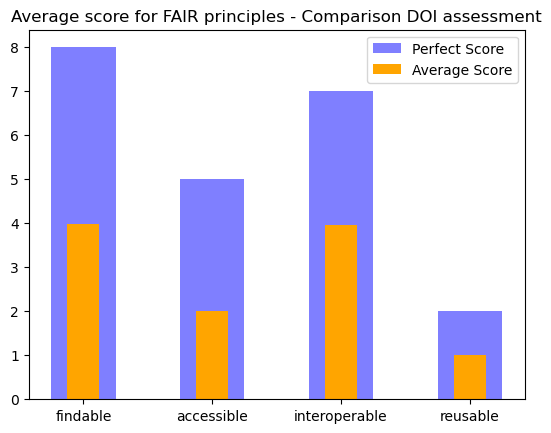

In [50]:
width = 0.5
perfect_scores = [8, 5, 7, 2]
actual_scores = comp_doi_df_principle['score_earned']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, comp_doi_df_principle['principle'] )
plt.title("Average score for FAIR principles - Comparison DOI assessment")
plt.legend()
plt.show()

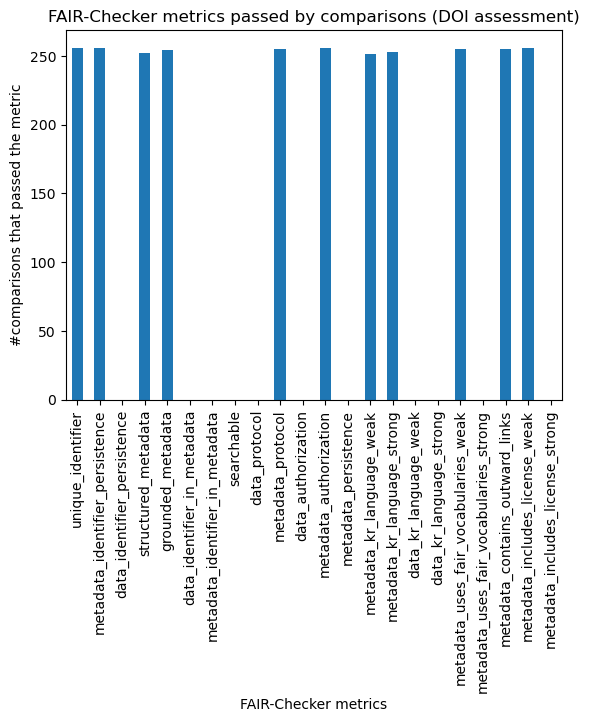

In [51]:
comp_doi_df_submetrics = comp_doi_df_assessed
comp_doi_df_submetrics = comp_doi_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()

comp_doi_df_submetrics["metric"] = pd.Categorical(comp_doi_df_submetrics["metric"], metrics_ordered)
comp_doi_df_submetrics = comp_doi_df_submetrics.sort_values("metric")

comp_doi_df_submetrics["score_earned"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, metrics_ordered)
plt.title("FAIR-Checker metrics passed by comparisons (DOI assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIR-Checker metrics")
plt.show()

## Comparisons via ORKG resource URL

In [52]:
%%script false --no-raise-error
comp_doi_df = pd.read_csv("raw_data/comparison_query_result_2023-03-29.csv")
comp_doi_df = comp_doi_df[comp_doi_df["comparisons"].isna() == False].reset_index(drop=True)
count = 0
comp_doi_df["assessment_result"] = comp_doi_df["comparisons"].map(lambda x: get_assessment(url=x))
comp_doi_df.to_csv("assessed_data/comparison_url_df_fenough_assessment.csv")
comp_doi_df

Couldn't find program: 'false'


In [53]:
comp_url_df = pd.read_csv("assessed_data/comparison_url_df_fenough_assessment.csv", index_col=0)
comp_url_df = comp_url_df[comp_url_df["assessment_result"].isna() == False].reset_index(drop=True)
comp_url_df["assessment_result"] = comp_url_df["assessment_result"].map(lambda x: x.replace("\'", "\""))
comp_url_df["assessment_result"] = comp_url_df["assessment_result"].map(lambda x: x.replace("None", "\"None\""))
comp_url_df["assessment_result"] = comp_url_df["assessment_result"].map(lambda x: json.loads(x))
comp_url_df

,comparisons,doi,assessment_result
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,"[{'metric': 'metadata_identifier_persistence',..."
1,http://orkg.org/orkg/resource/R140449,10.48366/r140449,"[{'metric': 'metadata_identifier_persistence',..."
2,http://orkg.org/orkg/resource/R140463,10.48366/r140463,"[{'metric': 'unique_identifier', 'score': '1'}..."
3,http://orkg.org/orkg/resource/R140714,10.48366/r140714,"[{'metric': 'metadata_identifier_persistence',..."
4,http://orkg.org/orkg/resource/R140726,10.48366/r140726,"[{'metric': 'metadata_identifier_persistence',..."
...,...,...,...
1004,http://orkg.org/orkg/resource/R203903,NaN,"[{'metric': 'unique_identifier', 'score': '1'}..."
1005,http://orkg.org/orkg/resource/R204005,NaN,"[{'metric': 'metadata_identifier_persistence',..."
1006,http://orkg.org/orkg/resource/R288079,NaN,"[{'metric': 'metadata_authorization', 'score':..."
1007,http://orkg.org/orkg/resource/R288672,NaN,"[{'metric': 'unique_identifier', 'score': '1'}..."


In [54]:
comp_url_df_assessed = expand_comp_df(comp_url_df)
comp_url_df_assessed[comp_url_df_assessed["score_earned"] == "None"].value_counts("metric")

metric
metadata_contains_outward_links           10
metadata_identifier_in_metadata            9
data_kr_language_strong                    9
data_protocol                              8
grounded_metadata                          8
metadata_includes_license_strong           7
metadata_persistence                       6
data_kr_language_weak                      6
data_identifier_in_metadata                6
data_identifier_persistence                5
metadata_kr_language_strong                5
metadata_uses_fair_vocabularies_strong     4
metadata_protocol                          4
data_authorization                         4
metadata_kr_language_weak                  1
metadata_includes_license_weak             1
structured_metadata                        1
dtype: int64

In [55]:
comp_url_df_assessed["score_earned"] = comp_url_df_assessed["score_earned"].map(lambda x: x.replace("None", "0"))
comp_url_df_assessed["score_earned"] = comp_url_df_assessed["score_earned"].map(lambda x: int(x))
comp_url_df_assessed

,comparison,doi,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R140347,10.48366/r140347,metadata_identifier_persistence,0,1
1,http://orkg.org/orkg/resource/R140347,10.48366/r140347,metadata_authorization,1,1
2,http://orkg.org/orkg/resource/R140347,10.48366/r140347,unique_identifier,1,1
3,http://orkg.org/orkg/resource/R140347,10.48366/r140347,grounded_metadata,1,1
4,http://orkg.org/orkg/resource/R140347,10.48366/r140347,data_authorization,0,1
...,...,...,...,...,...
22193,http://orkg.org/orkg/resource/R288673,NaN,metadata_kr_language_weak,1,1
22194,http://orkg.org/orkg/resource/R288673,NaN,metadata_persistence,0,1
22195,http://orkg.org/orkg/resource/R288673,NaN,searchable,0,1
22196,http://orkg.org/orkg/resource/R288673,NaN,metadata_uses_fair_vocabularies_strong,0,1


In [56]:
comp_url_df_total = comp_url_df_assessed.groupby("comparison").agg({"doi": "first", "score_earned": "sum"}).reset_index()
print_summary_stats(comp_url_df_total["score_earned"])

Mean: 6.953419226957384
Median: 7.0
Min: 3
Max: 7


In [57]:
comp_url_df_principle = comp_url_df_assessed
comp_url_df_principle["principle"] = comp_url_df_principle["metric"].map(lambda x: metric_to_principle[x])
comp_url_df_principle = comp_url_df_principle.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
comp_url_df_principle["score_earned"] = comp_url_df_principle["score_earned"]/len(comp_url_df)
comp_url_df_principle["score_total"] = comp_url_df_principle["score_total"]/len(comp_url_df)
comp_url_df_principle['principle'] = pd.Categorical(comp_url_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
comp_url_df_principle = comp_url_df_principle.sort_values('principle')
comp_url_df_principle

,principle,score_earned,score_total
1,findable,2.978196,8.0
0,accessible,1.996036,5.0
2,interoperable,1.979187,7.0
3,reusable,0.000000,2.0


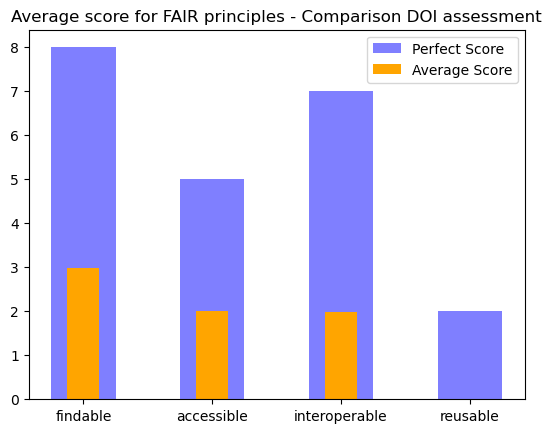

In [58]:
width = 0.5
perfect_scores = [8, 5, 7, 2]
actual_scores = comp_url_df_principle['score_earned']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, comp_url_df_principle['principle'] )
plt.title("Average score for FAIR principles - Comparison DOI assessment")
plt.legend()
plt.show()

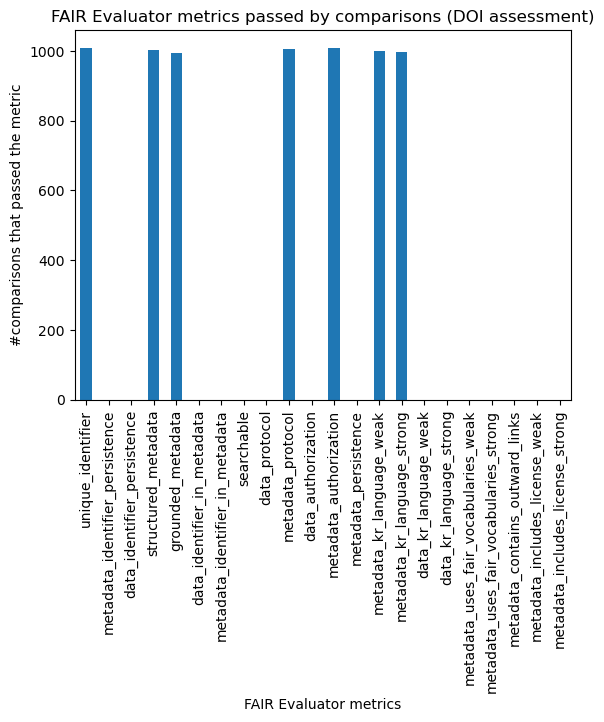

In [59]:
comp_url_df_submetrics = comp_url_df_assessed
comp_url_df_submetrics = comp_url_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()

comp_url_df_submetrics["metric"] = pd.Categorical(comp_url_df_submetrics["metric"], metrics_ordered)
comp_url_df_submetrics = comp_url_df_submetrics.sort_values("metric")

comp_url_df_submetrics["score_earned"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, metrics_ordered)
plt.title("FAIR Evaluator metrics passed by comparisons (DOI assessment)")
plt.ylabel("#comparisons that passed the metric")
plt.xlabel("FAIR Evaluator metrics")
plt.show()

## Comparison of Comparisons

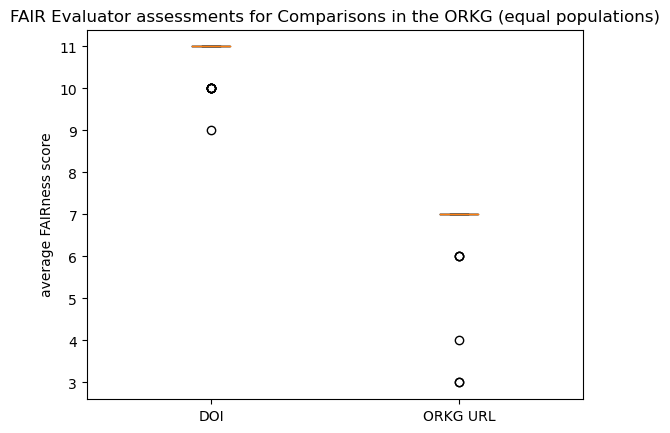

In [60]:
doi_orkg_df = pd.merge(comp_doi_df_total, comp_url_df_total, on=["comparison", "doi"], suffixes=("_doi", "_orkg"))
assessement_data_merged = [doi_orkg_df["score_earned_doi"], doi_orkg_df["score_earned_orkg"]]
plt.boxplot(assessement_data_merged)
plt.title("FAIR Evaluator assessments for Comparisons in the ORKG (equal populations)")
locs, labels = plt.xticks()
plt.xticks(locs, ["DOI", "ORKG URL"])
plt.ylabel("average FAIRness score")
plt.show()

# Resources

In [61]:
def expand_resource_df(df):
    df_exp = pd.DataFrame()
    df_exp["resource"] = list(chain.from_iterable([[x]*22 for x in df["resources"]]))
    df_exp["type_rsrc"] = list(chain.from_iterable([[x]*22 for x in df["type_rsrc"]]))
    df_exp["type_other"] = list(chain.from_iterable([[x]*22 for x in df["type_other"]]))
    df_exp["metric"] = list(chain.from_iterable([get_metrics_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    df_exp["score_earned"] = list(chain.from_iterable([get_scores_from_result(assessment_result=x) for x in df["assessment_summary"]]))
    df_exp["score_total"] = list(chain.from_iterable([[1]*22 for x in df["resources"]]))
    df_exp = df_exp[["resource", "type_rsrc", "type_other", "metric", "score_earned", "score_total"]]
    return df_exp

In [62]:
%%script false --no-raise-error
resource_df = pd.read_csv("raw_data/resource_query_result_2023-04-05.csv")
resource_rsrc_df = resource_df[resource_df["type"].str.endswith("Resource")]
resource_others_df = resource_df[np.logical_not(resource_df["type"].str.endswith("Resource"))]
resource_df = pd.merge(resource_rsrc_df, resource_others_df, on="resources", how="outer", suffixes=("_rsrc", "_other"))
resource_df = resource_df[np.logical_not(resource_df["type_other"].str.endswith("Paper") | resource_df["type_other"].str.endswith("Comparison"))].reset_index(drop=True)
resource_df = resource_df.sample(n=3000, random_state=13)
resource_df = resource_df.reset_index(drop=True)
count = 0
resource_df["assessment_summary"] = resource_df["resources"].map(lambda x: get_assessment(x))
resource_df.to_csv("assessed_data/resource_df_fenough_assessment.csv")
resource_df

Couldn't find program: 'false'


In [63]:
resource_df = pd.read_csv("assessed_data/resource_df_fenough_assessment.csv", index_col=0)
resource_df = resource_df[resource_df["assessment_summary"].isna() == False].reset_index(drop=True)
resource_df["assessment_summary"] = resource_df["assessment_summary"].map(lambda x: x.replace("\'", "\""))
resource_df["assessment_summary"] = resource_df["assessment_summary"].map(lambda x: x.replace("None", "\"None\""))
resource_df["assessment_summary"] = resource_df["assessment_summary"].map(lambda x: json.loads(x))
resource_df_assessed = expand_resource_df(resource_df)
resource_df_assessed

,resource,type_rsrc,type_other,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,unique_identifier,1,1
1,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,metadata_identifier_persistence,0,1
2,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,metadata_authorization,1,1
3,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,structured_metadata,1,1
4,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,metadata_contains_outward_links,0,1
...,...,...,...,...,...,...
58757,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,metadata_uses_fair_vocabularies_weak,0,1
58758,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,structured_metadata,1,1
58759,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,data_identifier_in_metadata,0,1
58760,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,metadata_identifier_in_metadata,0,1


In [64]:
resource_df_assessed[resource_df_assessed["score_earned"] == "None"].value_counts("metric")

metric
data_kr_language_strong                   26
data_protocol                             18
data_authorization                        17
metadata_kr_language_strong               17
data_identifier_in_metadata               15
metadata_identifier_in_metadata           15
grounded_metadata                         14
metadata_uses_fair_vocabularies_strong    14
metadata_persistence                      13
structured_metadata                       12
data_kr_language_weak                     11
metadata_includes_license_weak            11
metadata_contains_outward_links           10
metadata_includes_license_strong          10
data_identifier_persistence               10
metadata_kr_language_weak                 10
metadata_protocol                          8
metadata_authorization                     3
dtype: int64

In [65]:
resource_df_assessed["score_earned"] = resource_df_assessed["score_earned"].map(lambda x: x.replace("None", "0"))
resource_df_assessed["score_earned"] = resource_df_assessed["score_earned"].map(lambda x: int(x))
resource_df_assessed

,resource,type_rsrc,type_other,metric,score_earned,score_total
0,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,unique_identifier,1,1
1,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,metadata_identifier_persistence,0,1
2,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,metadata_authorization,1,1
3,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,structured_metadata,1,1
4,http://orkg.org/orkg/resource/R145348,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Contribution,metadata_contains_outward_links,0,1
...,...,...,...,...,...,...
58757,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,metadata_uses_fair_vocabularies_weak,0,1
58758,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,structured_metadata,1,1
58759,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,data_identifier_in_metadata,0,1
58760,http://orkg.org/orkg/resource/PWC_CONTEXT_AWAR...,http://orkg.org/orkg/class/Resource,http://orkg.org/orkg/class/Model,metadata_identifier_in_metadata,0,1


In [66]:
resource_df_total = resource_df_assessed.groupby("resource").agg({"type_rsrc": "first", "type_other": "first", "score_earned": "sum"}).reset_index()
print_summary_stats(resource_df_total["score_earned"])

Mean: 6.996995869320315
Median: 7.0
Min: 5
Max: 14


In [67]:
resource_df_principle = resource_df_assessed
resource_df_principle["principle"] = resource_df_principle["metric"].map(lambda x: metric_to_principle[x])
resource_df_principle = resource_df_principle.groupby("principle").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()
resource_df_principle["score_earned"] = resource_df_principle["score_earned"]/len(resource_df)
resource_df_principle["score_total"] = resource_df_principle["score_total"]/len(resource_df)
resource_df_principle['principle'] = pd.Categorical(resource_df_principle['principle'], ['findable', 'accessible', 'interoperable', 'reusable'])
resource_df_principle = resource_df_principle.sort_values('principle')
resource_df_principle

,principle,score_earned,score_total
1,findable,2.990266,8.0
0,accessible,1.995882,5.0
2,interoperable,1.989891,7.0
3,reusable,0.000000,2.0


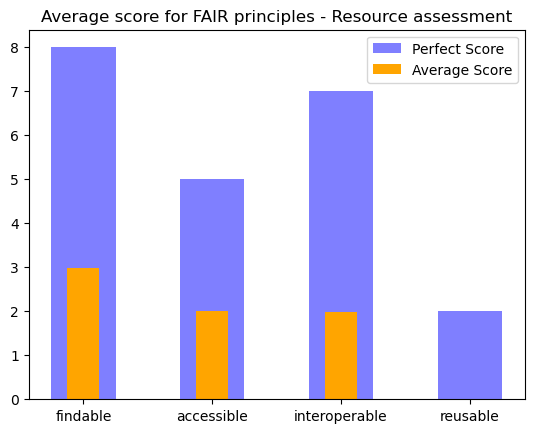

In [68]:
width = 0.5
perfect_scores = [8, 5, 7, 2]
actual_scores = resource_df_principle['score_earned']
indices = np.arange(len(perfect_scores))

plt.bar(indices, perfect_scores, width=width, color='b', alpha=0.5, label='Perfect Score')
plt.bar([i for i in indices], actual_scores, width=0.5*width, color='orange', label='Average Score')
plt.xticks(indices, resource_df_principle['principle'] )
plt.title("Average score for FAIR principles - Resource assessment")
plt.legend()
plt.show()

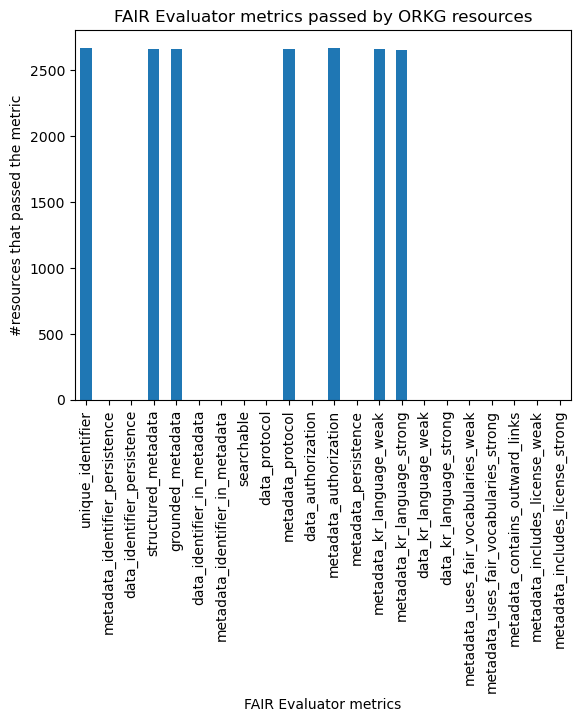

In [69]:
resource_df_submetrics = resource_df_assessed
resource_df_submetrics = resource_df_submetrics.groupby("metric").agg({"score_earned": "sum", "score_total": "sum"}).reset_index()

resource_df_submetrics["metric"] = pd.Categorical(resource_df_submetrics["metric"], metrics_ordered)
resource_df_submetrics = resource_df_submetrics.sort_values("metric")

resource_df_submetrics["score_earned"].plot(kind="bar")
locs, labels = plt.xticks()
plt.xticks(locs, metrics_ordered)
plt.title("FAIR Evaluator metrics passed by ORKG resources")
plt.ylabel("#resources that passed the metric")
plt.xlabel("FAIR Evaluator metrics")
plt.show()

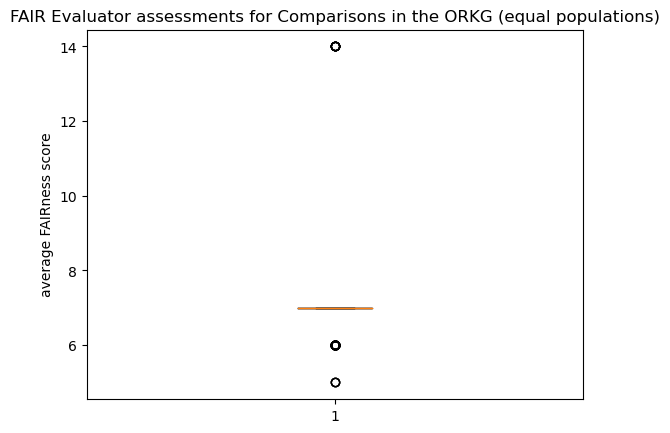

In [70]:
plt.boxplot(resource_df_total["score_earned"])
plt.title("FAIR Evaluator assessments for Comparisons in the ORKG (equal populations)")
plt.ylabel("average FAIRness score")
plt.show()